# Analyzing 1D Densities in the Core

In [105]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from scipy.signal import argrelextrema

import dgutils
from dgutils import colors as colortools
from numpy import pi as π
from wetting_utils import *
from collections import defaultdict
import matplotlib.transforms as mtransforms
from heprops import helium,potential
from pimcscripts import pimchelp


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load Radial Density Data from Disk

In [98]:
L = 25 # Å
element = ['Ar','Cs']
R = np.array([6.0,8.0])
μ = np.array([-5.0,-18.0,-40.0, -58.0])

ϱ = {}
est = {}
μval = {}
μmin_max = {}
N = {}

def lab(element,R):
    return f'{element} {R:.1f} Å'

for el in element:
    for cR in R:
        ϱ[lab(el,cR)] = pimchelp.PIMCResults(f'../data/pimc/{el}R{int(cR)}/radial-u-reduce.dat')
        est[lab(el,cR)] = pimchelp.PIMCResults(f'../data/pimc/{el}R{int(cR)}/estimator-u-reduce.dat')
        
        # we get a vector of μ values from the params
        μval[lab(el,cR)] = np.array([float(par.split("=", 1)[-1]) for par in ϱ[lab(el,cR)].params])
        μmin_max[el,cR] = (μval[lab(el,cR)].min(),μval[lab(el,cR)].max())

        # get the minimum and maximum # particles for each element and radius
        N[lab(el,cR)] = np.array([normalize_psi_PIMC(ϱ[lab(el,cR)].y(par),ϱ[lab(el,cR)].x(par)) for par in ϱ[lab(el,cR)].params])

## Determine the location of the first minimum for the maximal chemical potential

In [99]:
Rmin_idx = {}
for el in element:
    for cR in R:
        μmax_idx = np.argmax(μval[lab(el,cR)])
        _r,_ρ = ϱ[lab(el,cR)].pdata(ϱ[lab(el,cR)].params[μmax_idx])
        Rmin_idx[lab(el,cR)] = argrelextrema(_ρ, np.less)[0][0]
        print(el,R,f': {ϱ[lab(el,cR)].params[μmax_idx]}, {_r[Rmin_idx[lab(el,cR)]]}')


Ar [6. 8.] : u = -0.50, 1.65
Ar [6. 8.] : u = -0.50, 0.12
Cs [6. 8.] : u = 2.80, 0.06
Cs [6. 8.] : u = 2.80, 1.72


## Compute the 1D density at every chemical potential

\begin{equation}
\rho_{1d}(\mu) = 2\pi \int_0^{R_{\rm min}} r dr \varrho(r)
\end{equation}

In [100]:
ρ1d = {}
for el in element:
    for cR in R:
        _ρ1d = []
        idx = Rmin_idx[lab(el,cR)]

        for μpar in ϱ[lab(el,cR)].params:
            _r,_ρ = ϱ[lab(el,cR)].pdata(μpar)
            #print(el,cR,idx,_r[idx])
            
            #_ρ1d.append(2*π*intgr.simpson(y = _r[:idx]*_ρ[:idx], x = _r[:idx]))
            Δx = _r[1] - _r[0]
            _ρ1d.append(2*π*np.sum(_r[:idx]*_ρ[:idx])*Δx)

        ρ1d[lab(el,cR)] = np.array(_ρ1d)


Text(0, 0.5, '$\\rho_{1d}$ [Å$^{-1}$]')

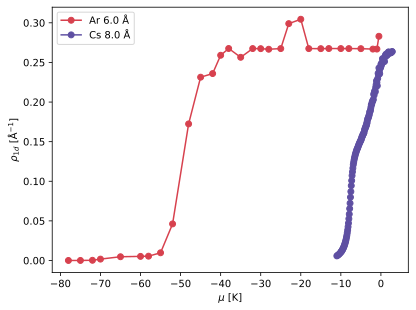

In [106]:
el,cR = 'Ar',6.0
plt.plot(μval[lab(el,cR)],ρ1d[lab(el,cR)], '-o', label=lab(el,cR), color=element_colors[el])
el,cR = 'Cs',8.0
plt.plot(μval[lab(el,cR)],ρ1d[lab(el,cR)], '-o', label=lab(el,cR), color=element_colors[el])
plt.legend()
plt.xlabel(r'$\mu$ [K]')    
plt.ylabel(r'$\rho_{1d}$ [Å$^{-1}$]')

## Now let's plot on a normalized scale

$$\mu_{min}, \mu_{max}$$

\begin{align}
y &= a \mu + b \\ 
y(\mu_{min}) &= 0 \Rightarrow b = -a \mu_{min} \\
y(\mu_{max}) &= 1 \Rightarrow 1-b = a \mu_{max}
\end{align}

Thus

\begin{align}
a &= \frac{1}{\mu_{max} - \mu_{min}} \\
b &= -\frac{\mu_{min}}{\mu_{max} - \mu_{min}} 
\end{align}

so 

\begin{equation}
y = \frac{1}{{\mu_{max} - \mu_{min}}} (\mu - \mu_{\rm min})
\end{equation}

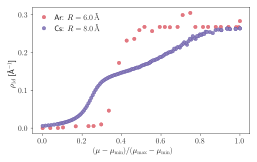

In [112]:
def y(μ,μmin,μmax):
    return (μ - μmin) / (μmax - μmin)

with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)
    trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)

    el,cR = 'Ar',6.0
    _y = y(μval[lab(el,cR)],μmin_max[el,cR][0],μmin_max[el,cR][1])
    ax.plot(_y,ρ1d[lab(el,cR)], 'o', label=f'{el}: $R = {cR:.1f}\,$'+r'${\rm \AA}$', mec=element_colors[el],
            mfc=colortools.get_alpha_hex(element_colors[el], 0.7),markersize=3.5, linewidth=0.5)

    el,cR = 'Cs',8.0
    _y = y(μval[lab(el,cR)],μmin_max[el,cR][0],μmin_max[el,cR][1])
    ax.plot(_y,ρ1d[lab(el,cR)], 'o', label=f'{el}: $R = {cR:.1f}\,$'+r'${\rm \AA}$', mec=element_colors[el],
            mfc=colortools.get_alpha_hex(element_colors[el], 0.7),markersize=3.5, linewidth=0.5)
    ax.legend()
    ax.set_xlabel(r'$(\mu - \mu_{\rm min})/(\mu_{\rm max}-\mu_{\rm min})$')    
    ax.set_ylabel(r'$\rho_{1d}$ [Å$^{-1}$]')

    plt.savefig('../figures/rho1d_vs_mu.pdf')

### This is good, but we would like to plot as a function of pressure

Skip line
1.4


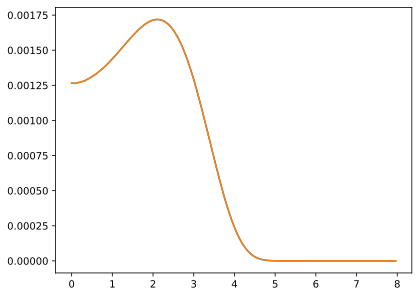

In [4]:
f2 = open('../data/pimc/CsR8/radial-u-reduce.dat','r')
lines = f2.readlines()
u = np.array([])
N = np.array([])
delN = np.array([])

readindex = 0
rval = len(lines) - 2

for line in lines:
    if(readindex == 0):
        p = line.split()
        for j in range(1,len(p)):
            if (j % 3 == 0):
                u = np.append(u,float(p[j]))
        r = np.zeros((len(u),rval))
        rho = np.zeros((len(u),rval))
        delrho = np.zeros((len(u),rval))
    elif(readindex == 1):
        print("Skip line")
    else:
        #print(r)
        p = line.split()
        #print(p)
        #print(readindex)
        ind_arr = 3*np.arange(0,int(len(p)/3),1)
        for j in ind_arr:
            ind = int(j/3)
            r[ind,readindex - 2] = p[j]
            #print(p[j+1])
            rho[ind,readindex - 2] = p[j+1]
            delrho[ind,readindex - 2] = p[j+2] 
        #print(rho)
    readindex = readindex + 1
f2.close()
plt.plot(r[len(u)-10,:],rho[len(u)-10,:])
refR = len(u)-10
#print(rho[refR,:])
#minR = np.argmin(rho[refR,:])
#minRval = r[refR,minR]
minRval = 1.4
print(minRval)
rho1d = np.array([])
for i in range(len(u)):
    indx = r[i,:] < minRval
    rho1d = np.append(rho1d,2*np.pi*intgr.simpson(y = r[i,indx]*rho[i,indx], x = r[i,indx]))
sind = np.argsort(u)
uCs = u[sind]
rho1dCs = rho1d[sind]
#rhostar = max(rho1dCs)
#rho1dCs = rho1dCs/rhostar
PCs = helium.pressure(uCs,2)
PCsmax = max(PCs)
PCsmin = min(PCs)
PCsPlot = (PCs - PCsmin)/PCsmax
plt.plot(r[refR,:],rho[refR,:])
#print(rho1dCs)
#u = np.delete(u,[16,17,18,19,20,21])
#rho1d = np.delete(rho1d,[16,17,18,19,20,21])
#print(u[16])
#print(rho1d[16])

#plt.semilogy(u,hel.pressure(u,2))
#plt.yscale("log")
#plt.semilogx(hel.pressure(u,2),rho1d)
#plt.plot(r[i],rho[i],label='u = %.4f'%(u[i]))
#plt.legend()
#plt.savefig('rhovsPCsR6.pdf')
#plt.show(

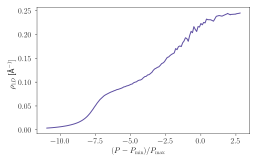

In [6]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],figsize[1]), constrained_layout=True)
    ax.plot(uCs,rho1dCs)
    #ax.semilogx(PCsPlot,rho1dCs,label=r'Cs',color='#5E4FA2')
    #ax.semilogx(PMgPlot,rho1dMg,label=r'Mg',color='#79C9A4')
    #ax.semilogx(PArPlot,rho1dAr,label=r'Ar',color='#D7414E')
    #ax.set_ylabel(r'$\frac{\rho_{1D}}{\rho_{1D}*}$')
    ax.set_xlabel(r'$(P - P_{\rm min})/P_{\rm max}$')
    #ax.set_xlim(1,1)
    ax.set_ylabel(r'$\rho_{1D}$ [Å$^{-1}]$')
    #ax.set_xlabel(r'$P$')
    #plt.legend(title="R = 8 Å",handlelength=1)
    plt.savefig('../figures/R8rho1d.pdf')